# Data Checks

Quick overview of data checks and explorations for a session of XX data.

In [1]:
from convnwb.io import load_nwbfile

from spiketools.measures.spikes import compute_firing_rate
from spiketools.plts.spatial import plot_position_by_time, plot_position_1d
from spiketools.plts.spikes import plot_firing_rates
from spiketools.plts.trials import plot_rasters
from spiketools.utils.timestamps import convert_sec_to_min

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from convnwb.io import load_nwbfile

#from spiketools.measures.collections import detect_empty_time_ranges
#from spiketools.measures.spikes import compute_firing_rate, compute_presence_ratio
from spiketools.spatial.occupancy import compute_occupancy
from spiketools.plts.data import plot_bar, plot_hist, plot_lines
from spiketools.plts.spatial import plot_positions, plot_heatmap
from spiketools.plts.spikes import plot_firing_rates
from spiketools.plts.trials import plot_rasters
from spiketools.plts.utils import make_axes
from spiketools.plts.annotate import add_hlines, add_vlines
#from spiketools.utils.timestamps import convert_sec_to_min, sum_time_ranges
from spiketools.utils.extract import get_range, get_value_by_time, get_values_by_time_range, drop_range
from spiketools.utils.epoch import epoch_data_by_range
from spiketools.utils.data import compute_range
from spiketools.utils.base import count_elements

In [2]:
# Local imports
import sys
sys.path.append('../code')
from plts import plot_task_structure

## Settings

In [3]:
# Define the base data folder
data_folder = '/Users/weija/Data/Train_NWB/'

In [4]:
# Define subject information
session = {
    'experiment' : 'TRAIN',
    'subject' : 'R1219C',
    'session' : 0    
}

In [5]:
# Define any quality measures
empty_time_bin = 0.25

# Define bins to use 
bins =  21

# Define occupancy related settings
min_occ = 1
speed_thresh = 5e-6
time_thresh = 0.25


## Load Data

In [6]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)

In [7]:
# Check the NWBfile contents
nwbfile

root pynwb.file.NWBFile at 0x140554303919392
Fields:
  acquisition: {
    boundaries <class 'pynwb.behavior.Position'>,
    position <class 'pynwb.behavior.Position'>
  }
  data_collection: unknown
  devices: {
    Microwire Electrodes <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    BF electrode <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: Task: TRAIN (english)
  experimenter: ['Qasim, Salman' 'Jacobs, Joshua']
  file_create_date: [datetime.datetime(2023, 4, 19, 23, 12, 44, 954179, tzinfo=tzoffset(None, -14400))]
  identifier: XX
  institution: Columbia University
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  keywords: <StrDataset for HDF5 dataset "keywords": shape (3,), type "|O">
  lab: Electrophysiology, Memory, and Navigation Laboratory
  notes: The exact subtracted timestamp is: 116.9224482421875
  processing: {
    position_measures <class 'pynwb.base.Proces

## Task Structure
In the following, lines and colors means shadings are:

- trial start: red line 
- trial end: black line (in some trials, black line can be trial start and trial end) 
- response time: grey line
- hold period: green 
- movement period: orange 
- fixation period: purple 
- feed back period: blue 


In [8]:
# Get the number of trials 
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 64


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

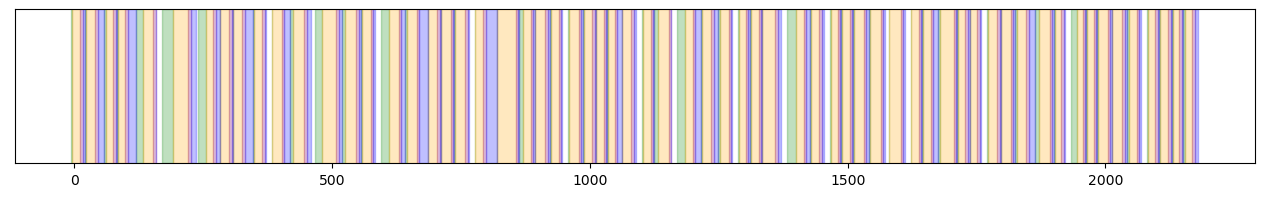

In [9]:
# Plot the task structure for the whole recording 
plot_task_structure(nwbfile.trials)

In [ ]:
# Plot the task structure for 1 trial
plot_task_structure(nwbfile.trials, xlim=[-10, nwbfile.trials.stop_time[0]])

### check task time range

In [10]:
# Set start and stop time of the task (note that 0 is task start time)
task_range = [nwbfile.trials.start_time[0], nwbfile.trials.stop_time[-1]]

# Compute the task length, in minutes
task_len = convert_sec_to_min(task_range[1])

# Check the task / recording length, based on unit time
print('Task length: {:1.2f} minutes'.format(task_len))

Task length: 36.34 minutes


## General Checks

### Position Data Checks

In [11]:
# Grab the position data
pos = nwbfile.acquisition['position']['player_position']



In [12]:
ptimes = pos.timestamps[:]
positions = pos.data[:]
ptimes

array([0.00000000e+00, 9.99926758e-02, 1.99985840e-01, ...,
       2.16734716e+03, 2.16744715e+03, 2.16754714e+03])

array([0.00000000e+00, 9.99926758e-02, 1.99985840e-01, ...,
       2.16734716e+03, 2.16744715e+03, 2.16754714e+03])

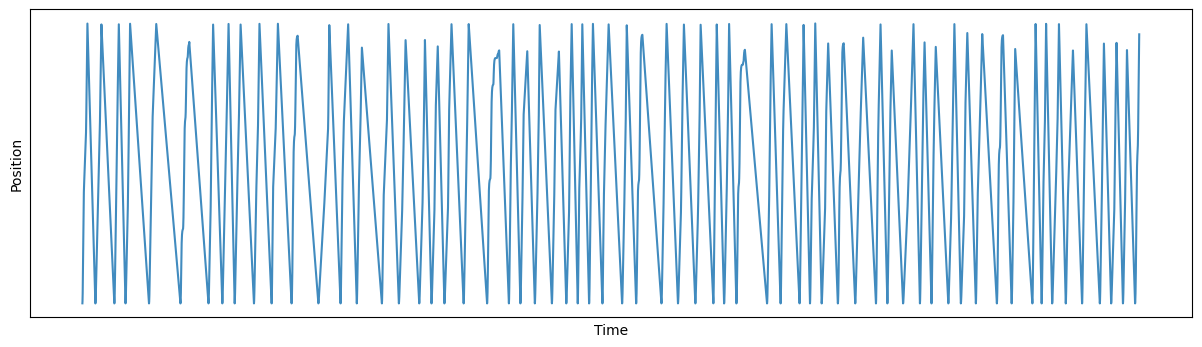

In [13]:
# Plot position across time
plot_position_by_time(pos.timestamps[:], pos.data[:], alpha=0.85, figsize=(15, 4))
ptimes

In [14]:
# Get boundary ranges 
pos_trial_range = nwbfile.acquisition['boundaries']['track_range'].data[:]
pos_trial_center =nwbfile.acquisition['boundaries']['track_center'].data[:]

# Check position ranges & compare to boundaries
print('Trial position range : \t{:6.2f} - {:6.2f}'.format(*pos_trial_range))
print('Trial center:   {:1.2f} '.format(*pos_trial_center))

Trial position range : 	-34.00 -  34.00
Trial center:   0.00 


### Check speed

Text(0, 0.5, 'frequency')

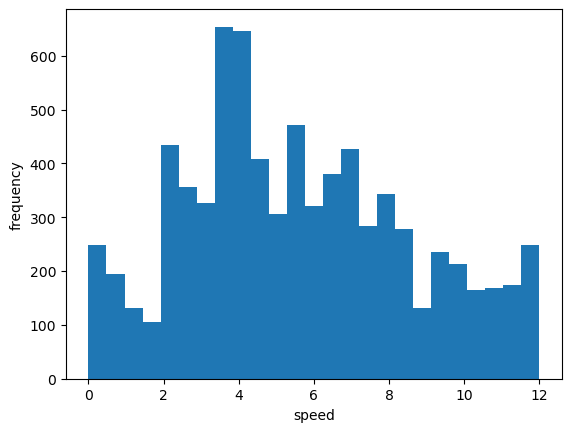

In [15]:
speed = nwbfile.processing['position_measures']['speed'].data[:]
# Plot the histogram of speed values
plot_hist(speed, bins=25)
plt.xlabel('speed')
plt.ylabel('frequency')

Text(0, 0.5, 'speed')

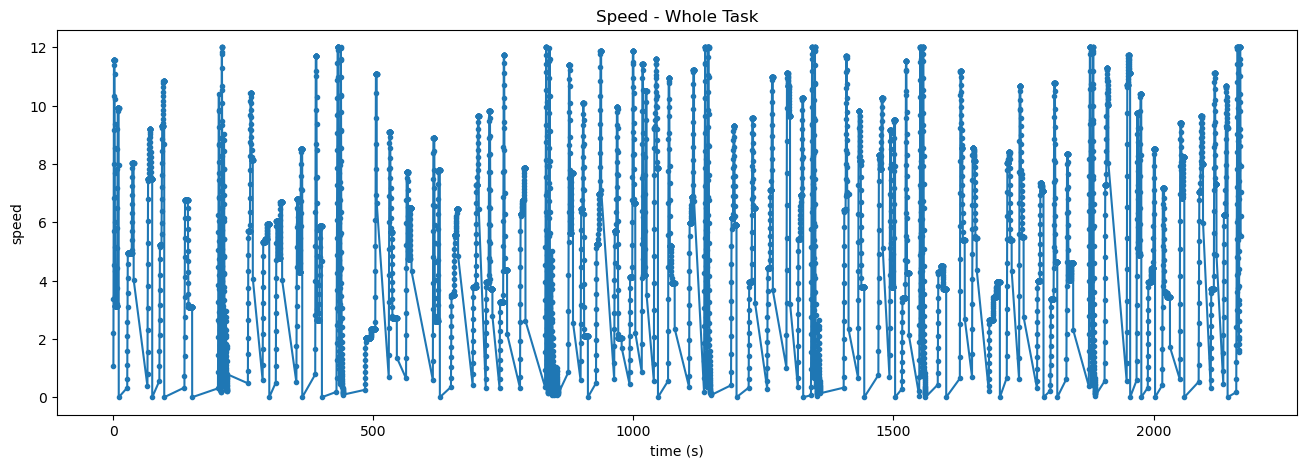

In [16]:
# Plot the speed across the whole task
plot_lines(ptimes, speed, marker='.', title='Speed - Whole Task', figsize=(16, 5))
plt.xlabel('time (s)')
plt.ylabel('speed')
#add_hlines(speed_thresh, color='red', alpha=0.75, linestyle='--')

Text(0, 0.5, 'speed')

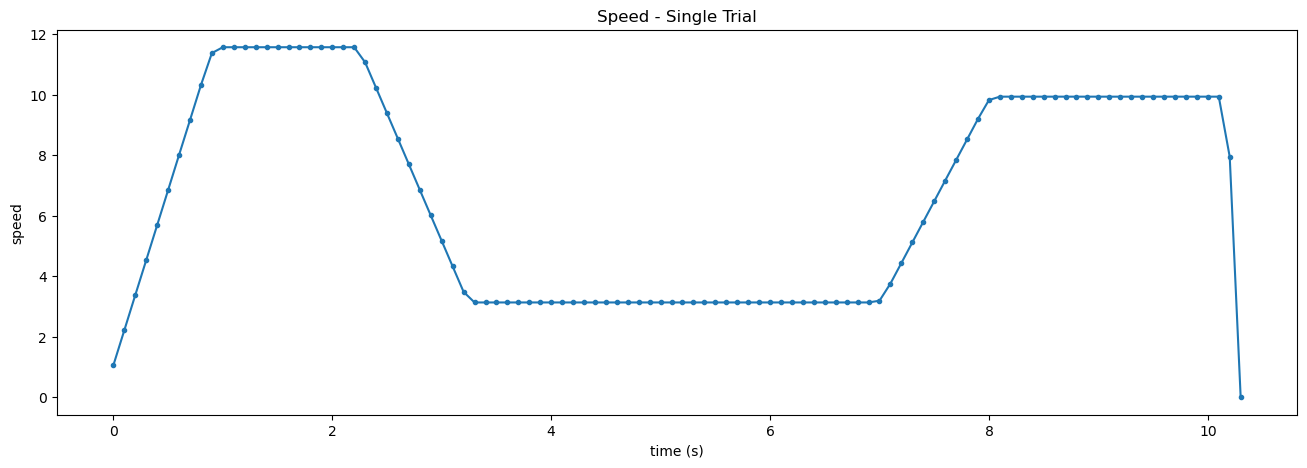

In [17]:
# Extract speed across a single navigation period (trial)
t_ind = 0
t_times, t_speed = get_values_by_time_range(
    ptimes, speed, nwbfile.trials.start_time[t_ind], nwbfile.trials.stop_time[t_ind])

# Plot the speed across a single navigation session (one trial)
plot_lines(t_times, t_speed, marker='.', title='Speed - Single Trial', figsize=(16, 5))
plt.xlabel('time (s)')
plt.ylabel('speed')
#add_hlines(speed_thresh, color='red', alpha=0.75, linestyle='--')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

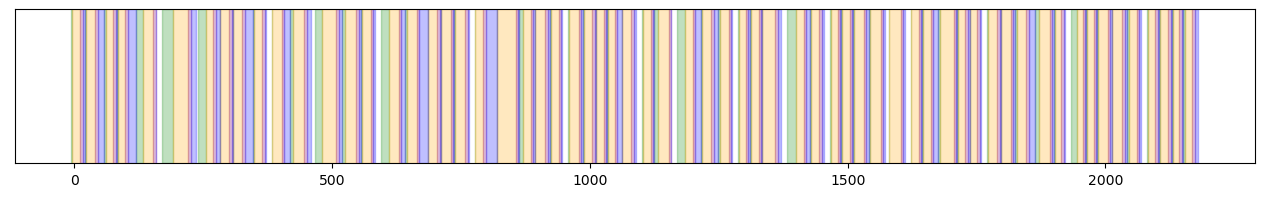

In [18]:
# Check when position times are samples across a single trial
plot_task_structure(nwbfile.trials,
                    data_points=get_range(ptimes,nwbfile.trials.movement_start_time[0], nwbfile.trials.stop_time[1]),
                    xlim=[-10, nwbfile.trials.stop_time[1]])

### Check for Occupancy 

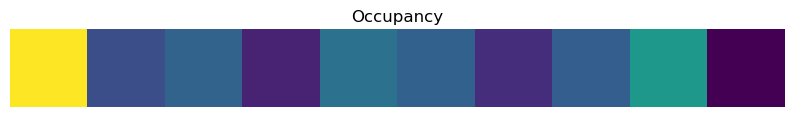

In [19]:
# Collect settings for occupancy
# TODO: add speed threshold 
time_thresh = 0.1
min_occ = 0
occ_kwargs = {'time_threshold' : time_thresh, 'minimum' : min_occ,
              'normalize' : True, 'set_nan' : True}

# Compute occupancy values
occ = compute_occupancy(positions, ptimes, bins = [10],**occ_kwargs)

# Plot the occupancy
plot_heatmap(occ, title="Occupancy", figsize=(10, 5))

In [20]:
# time_thresh: maximum time duration for sample to be included 
# default to be 250ms if the position sample larger than 250ms the gap get dropped. 
# assigning position/spike to time 

# speed_thresh: drop the position when the speed is below certain number 
occ

array([0.14355391, 0.09425257, 0.0992618 , 0.0847614 , 0.10268917,
       0.09873451, 0.0871342 , 0.09794358, 0.11310309, 0.07856578])

### Check for object locations 

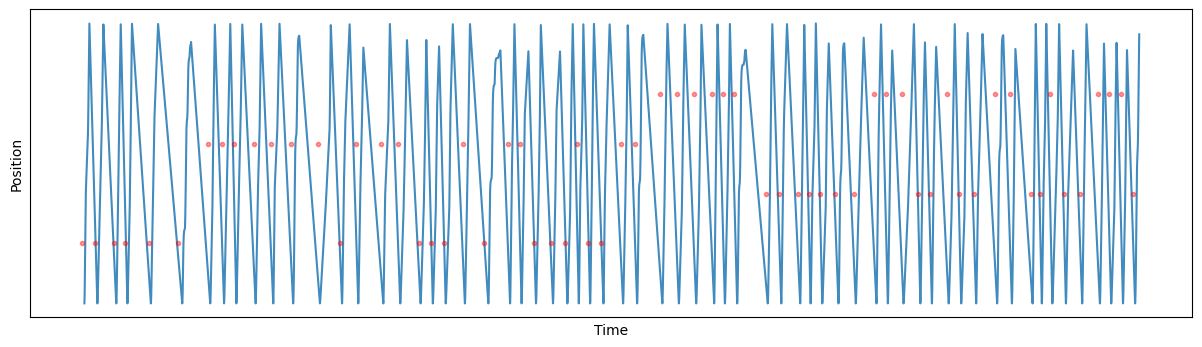

In [25]:
# Collect chest positions
obj_pos = nwbfile.trials['object_position'].data[:]
obj_times = nwbfile.trials['movement_start_time'].data[:]

# Plot the subject positions, overlaid with chest positions

# Plot position across time
plot_position_by_time(pos.timestamps[:], pos.data[:],obj_times,obj_pos,alpha=0.85, figsize=(15, 4))
#plt.scatter(obj_times, obj_pos, marker='.', color='green')



Text(0.5, 1.0, 'object positions')

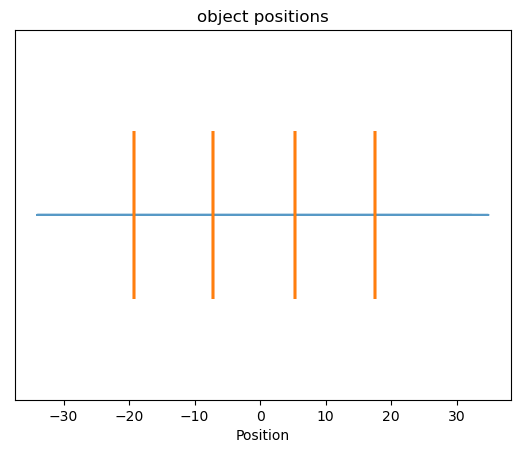

In [27]:
plot_position_1d(positions, obj_pos)
plt.title('object positions')
#plt.ylabel('speed')

### Check for response locations 

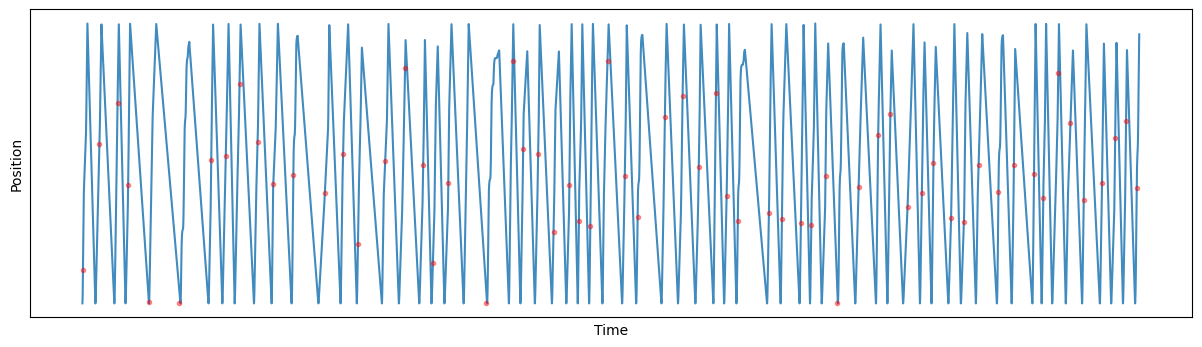

In [26]:
# Collect chest positions
res_pos = nwbfile.trials['response_position'].data[:]
res_times = nwbfile.trials['response_time'].data[:]

# Plot the subject positions, overlaid with chest positions

# Plot position across time
plot_position_by_time(pos.timestamps[:], pos.data[:],res_times,res_pos, alpha=0.85, figsize=(15, 4))
#plt.scatter(res_times, res_pos, marker='.', color='purple')



Text(0.5, 1.0, 'response positions')

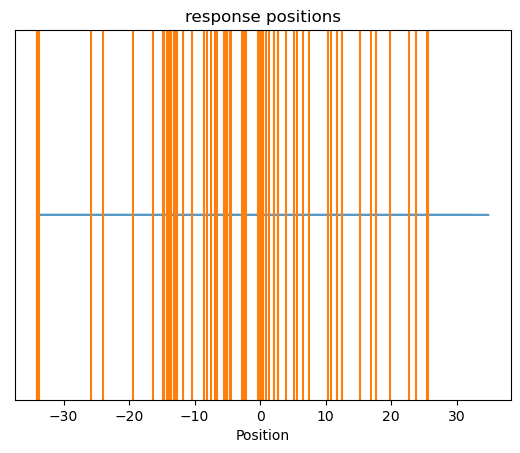

In [28]:
plot_position_1d(positions, res_pos)
plt.title('response positions')

### Check Events

In [38]:
# Check the trials data
nwbfile.trials

trials pynwb.epoch.TimeIntervals at 0x6110328576
Fields:
  colnames: ['start_time' 'stop_time' 'drive_type' 'feedback_start_time'
 'feedback_stop_time' 'fixation_start_time' 'fixation_stop_time'
 'hold_start_time' 'hold_stop_time' 'movement_start_time'
 'movement_stop_time' 'object' 'object_position' 'response_error'
 'response_position' 'response_time' 'trial_type']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    drive_type <class 'hdmf.common.table.VectorData'>,
    feedback_start_time <class 'hdmf.common.table.VectorData'>,
    feedback_stop_time <class 'hdmf.common.table.VectorData'>,
    fixation_start_time <class 'hdmf.common.table.VectorData'>,
    fixation_stop_time <class 'hdmf.common.table.VectorData'>,
    hold_start_time <class 'hdmf.common.table.VectorData'>,
    hold_stop_time <class 'hdmf.common.table.VectorData'>,
    movement_start_time <class 'hdmf.common.table.VectorData'>,
    movement_sto

In [39]:
# Check the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {:d}'.format(n_trials))

Number of trials: 64


In [40]:
# Get the trial information as a dataframe
behav = nwbfile.trials.to_dataframe()
behav.head()
ptimes

array([0.00000000e+00, 9.99926758e-02, 1.99985840e-01, ...,
       2.16734716e+03, 2.16744715e+03, 2.16754714e+03])

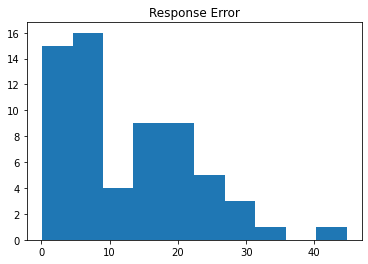

In [41]:
# plot response error
plot_hist(nwbfile.trials['response_error'].data[:], title='Response Error')

### Check Unit Data

In [42]:
# Check the units data
nwbfile.units

units pynwb.misc.Units at 0x6110327664
Fields:
  colnames: ['channel' 'spike_times' 'electrodes']
  columns: (
    channel <class 'hdmf.common.table.VectorData'>,
    spike_times_index <class 'hdmf.common.table.VectorIndex'>,
    spike_times <class 'hdmf.common.table.VectorData'>,
    electrodes_index <class 'hdmf.common.table.VectorIndex'>,
    electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  )
  description: Spike sorting solutions - done with XX by XX.
  id: id <class 'hdmf.common.table.ElementIdentifiers'>

In [43]:
# Check how many units are available
n_units = len(nwbfile.units)
print('Number of unit: {}'.format(n_units))

Number of unit: 23


In [44]:
# Check the total number of spikes
print('Total number of spikes: {}'.format(nwbfile.units.spike_times.shape[0]))

Total number of spikes: 248614


In [45]:
# Get spiking activity from across all units
all_spikes = [nwbfile.units.get_unit_spike_times(uind) for uind in range(n_units)]

In [46]:
# Calculate the average overall firing rate of each neuron
rates = [compute_firing_rate(spikes) for spikes in all_spikes]

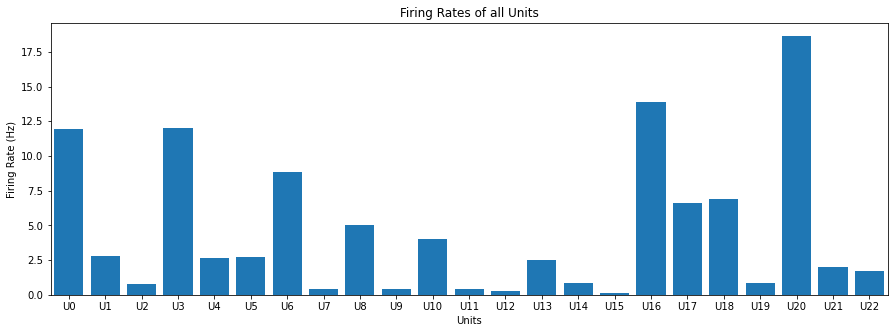

In [47]:
# Plot approximate firing rate for each unit
plot_firing_rates(rates, figsize=(15, 5))

In [57]:
# Set start and stop time of the task (note that 0 is task start time)
st = nwbfile.trials.start_time[0]
en = nwbfile.trials.stop_time[-1]

In [58]:
# Compute the task length, in minutes
task_len = convert_sec_to_min(en)

In [59]:
# Check the task / recording length, based on unit time
print('Task length: {:1.2f} minutes'.format(task_len))

Task length: 36.34 minutes


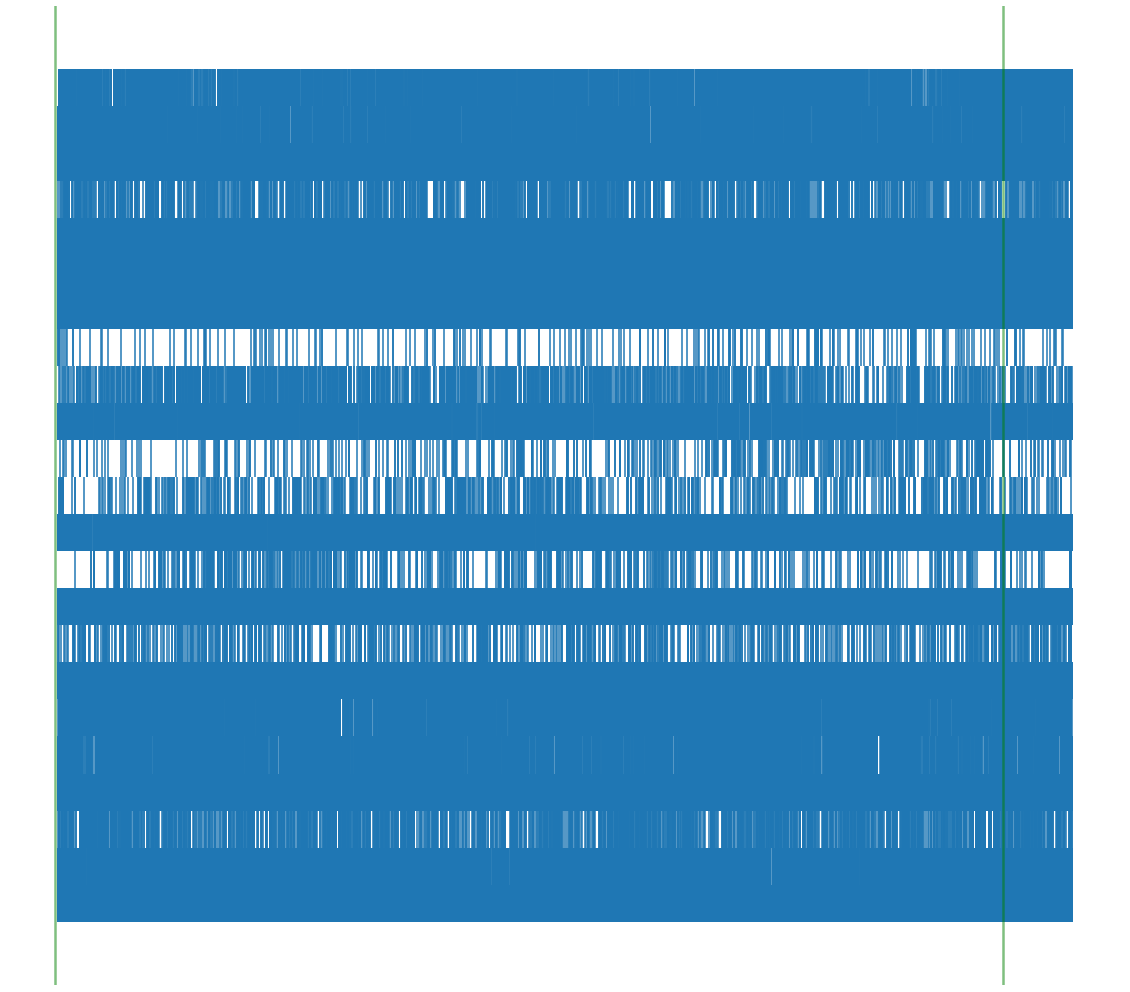

In [60]:
# Plot the session-level raster plot across all units together
plot_rasters(all_spikes, vline=[st, en], figsize=(20, 18))

## Descriptive Explorations
- explore some descriptive measures of spiking activity
- the spike times in this file are stored in milliseconds

### Spikes times

In [52]:

# Set index to access a unit of interest
s_ind = 0

# Extract spikes for the unit of interest
spikes = nwbfile.units.get_unit_spike_times(s_ind)

# Check an example selection of spike times
spikes[0:10]


array([0.298     , 0.39496667, 0.5477    , 0.57296667, 1.17996667,
       1.3802    , 1.56773333, 1.5756    , 1.78803333, 1.84843333])

### Firing Rate
An initial, simple measure of unit activity is it's firing rate, which we can compute as the amount of spiking over some unit time. 

The firing rate is: 11.93


<BarContainer object of 23 artists>

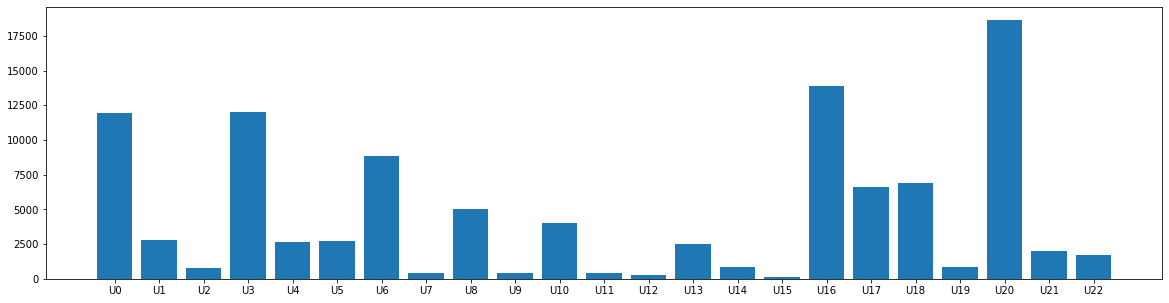

In [53]:

def compute_spike_rate(spikes):
    """Estimate spike rate from a vector of spike times, in seconds."""
    
    return len(spikes) / (spikes[-1] - spikes[0])

def get_spike_time_range(spikes, tmin, tmax):
    """Extract spike times for a particular time range."""
    
    return spikes[np.squeeze(np.logical_and([spikes > tmin], [spikes < tmax]))]


# Compute the firing rate of the neuron 
fr = compute_spike_rate(spikes)

# Check the firing rate of the unit of interest
print('The firing rate is: {:2.2f}'.format(fr))

# Compute the firing rate for all neurons
frs = [compute_spike_rate(nwbfile.units.get_unit_spike_times(ind)) * 1000 \
    for ind in range(n_units)]

# Plot the firing rate for all neurons
labels = ['U' + str(ind) for ind in range(len(frs))]
_, ax = plt.subplots(figsize=(20, 5))
ax.bar(labels, frs)

### inter-spike interval
- Look at the time interval between each spike (aka the interspike interval)
- By computing the inter-spike interval between all spikes, we can examine the distribution of interspike intervals. This gives us someinformation about the patterns of unit firing

/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_46505/2562527553.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(isi)


Text(0, 0.5, 'density')

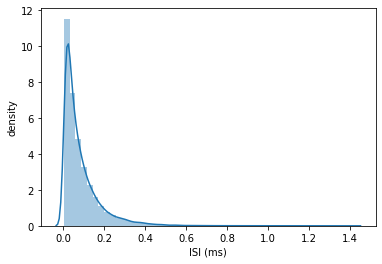

In [54]:
# Compute ISI for a single neuron
isi = np.diff(np.array(spikes))

# Plot the inter-spike intervals
sns.distplot(isi)
plt.xlabel('ISI (ms)')
plt.ylabel('density')

### Coefficient of Variation 
- From the ISI distribution, you can compute the coefficient of variation. 
- Note that the CV does not vapture potential variability on longer time scales especially if there's drifit in the neurons mean firing rate over time. 
- Bursty neuron: a neuron that tends to fire a lot of action potentials in short bursts, rather than as isolated single spikes
    - tend to violate Poisson assumption 
    - have ISI distributions that look a little more bimodal, with lots of spikes close together, and lots of bursts far apart

In [55]:
# Compute coefficient of variation
cv = np.std(isi) / np.mean(isi)
# Check the computed CV
print(cv)

1.1425758665939503


## Data Representations
- Spike Times: a list of times at which a unit fired
- Spike Trains: binary representation of 0's and 1's, in which each value represents whether the unit spiking (1) or not (0)
- Continuous Firing Rates: One main reason to use spike trains is in order to compute continuous firing rates. By sweeping across windows in the soike train, and computing the firing rate within each time bin, we can compute a continuous measure of spike rate over time.

### Computing Spike Trains

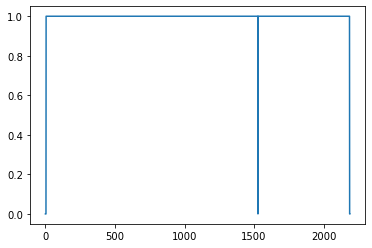

In [61]:
# Settings
bin_width_st = 1   # this means our time resolution is 1 ms
st_sr = 1000       # This is our sampling rate 

# Extract start & stop time of the task from the event log
start = nwbfile.trials['start_time'][0]
end = nwbfile.trials['stop_time'][-1]

# Extract spikes from during the task time
#   First we find indices to keep, and then re-align time to 0
keep_inds = np.where(np.logical_and(spikes>=start, spikes<=end))[0].astype(int)
task_spikes = spikes[keep_inds] - start

task_spikes
# # Spike times are in ms, but are sampled at 30 KHz 
# #   This means we have to round them to ms resolution
rounded_spike_times = np.round(task_spikes).astype(int)
rounded_spike_times
# # Generate a spike train - a binary vector of 0's and 1's that is indexed by the spike times. 
n_vals = int(((np.ceil(end) - np.floor(start)) / bin_width_st) + 1)
spiketrain = np.zeros(n_vals)
spiketrain
# # Add the spikes - note we have to subtract 1 for pythonic indexing
spiketrain[rounded_spike_times - 1] = 1 
spiketrain[0:100]
rounded_spike_times[0:100]
# # Plot the spike train
plt.plot(spiketrain)

In [91]:
# Extract the time for the responses per trial
all_response_times = nwbfile.intervals['trials'].response_time.data[:]
# Define a time window of interest for around events
time_window = [-2, 2]
# Extract the spikes surrounding each stimulus 
spike_times_per_event = [] 
for response in all_response_times:
    keep_event_inds = np.where(np.logical_and(task_spikes >= response + time_window[0], 
                                              task_spikes <= response + time_window[1]))[0].astype(int)
    spike_times_per_event.append(task_spikes[keep_event_inds] - response)
    
# Plot the raster
f, (raster, spike_hist) = plt.subplots(2, 1, figsize=[6,6])
trial = 1
for row in spike_times_per_event: 
    raster.vlines(row, trial, trial+1)
    trial += 1
raster.vlines(0, 0, trial)

# Compute the histogram in 50 ms bins
bin_width_ms = 50 
n_bins = int(1000 / bin_width_ms)
H, b = np.histogram(np.hstack(spike_times_per_event), n_bins)
rate_factor = (bin_width_ms * len(nwbfile.intervals['trials']) / 1000)

sns.distplot(np.hstack(spike_times_per_event), bins=n_bins, kde=False, ax=spike_hist)
# Scale the y-axis so we are plotting firing rate in our bins, not just counts of spikes 
y_vals = spike_hist.get_yticks()
spike_hist.set_yticklabels(['{:3.1f}'.format(x/rate_factor) for x in y_vals])
spike_hist.vlines(0, 0, y_vals.max())

NameError: name 'task_spikes' is not defined